In [1]:
import warnings
import nltk

warnings.filterwarnings('ignore')
nltk.download("all", quiet=True)


True

In [2]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [3]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.disable_caching()

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [4]:
import numpy as np
from nltk.tokenize import word_tokenize

def tokenize(texts):
    max_len = 0
    tokenized_texts = []
    word2idx = {}
    
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)
        tokenized_texts.append(tokenized_sent)
        
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
                
        max_len = max(max_len, len(tokenized_sent))
        
    return tokenized_texts, word2idx, max_len


def encoding(tokenized_texts, word2idx, max_len=100):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        if len(tokenized_sent) > max_len:
            tokenized_sent = tokenized_sent[:max_len]
            
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))
        
        input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)


train_tokenized, word2idx, max_len = tokenize(vispam_datasets['train']['clean_tokenized_comment'])
print("Number of words:", len(word2idx))
print("Max length of sentence:", max_len)


Number of words: 17196
Max length of sentence: 217


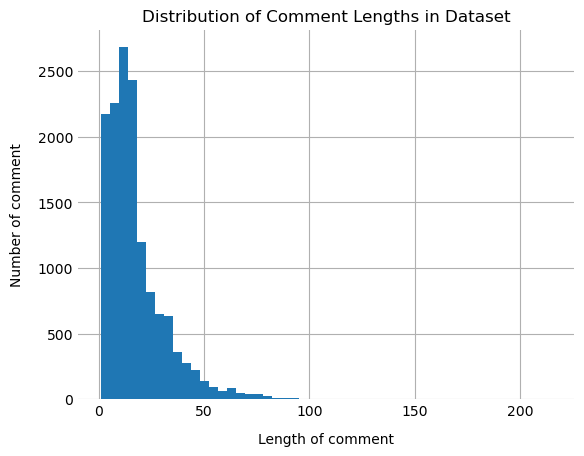

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist([len(s.split()) for s in vispam_datasets['train']['clean_tokenized_comment']], bins=50)
ax.set_title('Distribution of Comment Lengths in Dataset', fontsize=12)
ax.set_xlabel("Length of comment", fontsize=10, labelpad=10)
ax.set_ylabel('Number of comment', fontsize=10, labelpad=10)
for pos in ['right', 'top', 'left', 'bottom']:
    ax.spines[pos].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.grid()
ax.set_axisbelow(True)
plt.show()

In [6]:
categories = set(vispam_datasets['train']['category'] + vispam_datasets['dev']['category'] + vispam_datasets['test']['category'])
category2idx = {p:i for i, p in enumerate(categories)}
num_categories = len(category2idx)
print("Number of categories:", num_categories)
print("Categories:", categories)


Number of categories: 12
Categories: {'Phương Tiện', 'Nhà Cửa - Đời Sống', 'Thời Trang', 'Điện Tử', 'Đồ Chơi', 'Điện Thoai - Máy Tính', 'Sắc Đẹp', 'Máy Ảnh', 'Sách', 'Thể Thao', 'Khác', 'Giày Dép'}


In [7]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_tokenized_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    category_ids = [category2idx[category] for category in examples['category']]
    
    return {'input_id': input_ids, "category_id": category_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [8]:
import torch
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, file_name):
    fin = open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))
    
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)
            
    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")
    
    return embeddings


embeddings = load_pretrained_vectors(word2idx, file_name="/kaggle/input/fasttext-pretrained-embeddings/cc.vi.300.vec")
embeddings = torch.tensor(embeddings)


0it [00:00, ?it/s]

There are 8362 / 17196 pretrained vectors found.


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MetaParamManager():
    def __init__(self):
        self.meta_em = {}

    def state_dict(self):
        return self.meta_em

    def register(self, name, param):
        self.meta_em[name] = param

        
class BasicWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(BasicWordEmbedding, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, input_ids):
        return self.embedding(input_ids).float()
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')

            
class CustWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, meta_units, meta_param_manager):
        super(CustWordEmbedding, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            # Word Embedding transformation parameters
            setattr(self, name, nn.Embedding(num_meta, embedding_dim*embedding_dim))
            meta_param_manager.register("CustWordEmbedding." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        x = self.embedding(x)
        r = None
        for name, idx in kwargs.items():
            v = getattr(self, name)(idx).view(x.shape[0], self.embedding_dim, self.embedding_dim)
            rv = torch.bmm(x, v)
            if (r is not None):
                r += rv
            else:
                r = rv
        # Residual addition
        x = x + torch.tanh(r)
        return x
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
    
    
class BasisCustWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, meta_units, meta_dim, key_query_size, num_bases, meta_param_manager):
        super(BasisCustWordEmbedding, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            # Word embedding transformation parameters
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustWordEmbedding." + name, getattr(self, name).weight)
            
        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, embedding_dim*embedding_dim),
        )

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        x = self.embedding(x)
        query = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        t = self.P(query).view(x.shape[0], self.embedding_dim, self.embedding_dim)
        r = torch.bmm(x, t)
        x = x + torch.tanh(r)
        return x
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
    
    
class TextCNN(nn.Module):
    def __init__(self, embedding_dim, kernel_sizes=[2, 3, 5], num_filters=32):
        super(TextCNN, self).__init__()
        
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        
    def forward(self, h_embedding):
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        return x
        
        
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiLSTM, self).__init__()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding):
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        return conc
        
        
class BiGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiGRU, self).__init__()
        
        self.gru = nn.GRU(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding):
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        return conc

    
class BasicLinear(nn.Module):
    def __init__(self, state_size, num_classes):
        super(BasicLinear, self).__init__()
        self.W = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, x):
        out = self.W(x)
        return out
    
    
class CustLinear(nn.Module):
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size*num_classes))
            meta_param_manager.register("CustLinear." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        W = torch.cat([getattr(self, name)(idx).view(x.shape[0], self.state_size, self.num_classes) for name, idx in kwargs.items()], dim=1)
        x = x.unsqueeze(dim=1).repeat(1, 1, len(kwargs))
        out = torch.bmm(x, W).squeeze(dim=1)
        return out
    
    
class BasisCustLinear(nn.Module):
    def __init__(self, meta_units, meta_dim, key_query_size, state_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustLinear." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            nn.Linear(meta_dim*len(meta_units), key_query_size),  # From MetaData to Query
            nn.Tanh(),
            # Calculate weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            nn.Linear(num_bases, state_size * num_classes),  # Weighted Sum of Bases
        )
        
    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        W = self.P(conc).view(x.shape[0], self.state_size, self.num_classes)
        out = torch.bmm(x.unsqueeze(dim=1), W).squeeze(dim=1)
        return out
    
    
class BasicBias(nn.Module):
    def __init__(self, num_classes):
        super(BasicBias, self).__init__()
        self.b = nn.Parameter(torch.zeros((1, num_classes)))

    def forward(self):
        return self.b
    
    
class CustBias(nn.Module):
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size))
            meta_param_manager.register("CustBias." + name, getattr(self, name).weight)
            
        self.Y = nn.Linear(state_size*len(meta_units), num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(conc)
        return out
    
    
class BasisCustBias(nn.Module):
    def __init__(self, meta_units, meta_dim, state_size, key_query_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustBias." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, state_size),
        )
        
        self.Y = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(self.P(conc))
        return out
    

In [10]:
import torch
from torch import nn

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, kernel_sizes=[2, 3, 5], num_filters=32, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(ViSpam_Classifier, self).__init__()
        
        self.model_name = model_name
        name, model_type = model_name.split('_')
        
        assert name in ['TextCNN', 'BiLSTM', 'BiGRU']
        assert model_type in ['CustBias', 'CustLinear', 'CustWordEmbedding', 'BasisCustBias', 'BasisCustLinear', 'BasisCustWordEmbedding']
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.meta_dim = 64
        self.key_query_size = 64
        self.num_bases = 4
        
        self.meta_param_manager = MetaParamManager()
        self.meta_units = [('category_id', num_categories)]
        
        # Word embedding
        if model_type == 'CustWordEmbedding':
            self.embedding = CustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustWordEmbedding':
            self.embedding = BasisCustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.embedding = BasicWordEmbedding(vocab_size=self.vocab_size, embedding_dim=self.embedding_dim)
            
        self.embedding.load_embeddings(mode)
        
        # Spatial dropout
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        else:
            self.dropout = nn.Dropout(drop)
        
        # Model
        if name == 'TextCNN':
            self.network = TextCNN(self.embedding_dim, kernel_sizes, num_filters)
            self.state_size = len(kernel_sizes)*num_filters
        elif name == 'BiLSTM':
            self.network = BiLSTM(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        else:
            self.network = BiGRU(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        
        # Linear
        if model_type == 'CustLinear':
            self.W = CustLinear(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustLinear':
            self.W = BasisCustLinear(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                state_size=self.state_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.W = BasicLinear(state_size=self.state_size, num_classes=self.num_classes)
            
        # Bias
        if model_type == 'CustBias':
            self.bias = CustBias(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustBias':
            self.bias = BasisCustBias(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                state_size=self.state_size,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.bias = BasicBias(self.num_classes)
            
    def forward(self, input_ids, category_id):
        batch_size, sequence_length = input_ids.shape
        
        if 'CustWordEmbedding' in self.model_name:
            h_embedding = self.embedding(input_ids, category_id)
        else:
            h_embedding = self.embedding(input_ids)
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        else:
            h_embedding = self.dropout(h_embedding)
        
        output_net = self.network(h_embedding)
        
        if 'CustLinear' in self.model_name:
            x = self.W(output_net, category_id)
        else:
            x = self.W(output_net)
        
        if 'CustBias' in self.model_name:
            x += self.bias(category_id)
        else:
            x += self.bias()
        
        return x
    

In [11]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [12]:
import os
import json
import numpy as np
from scipy import interpolate
from pathlib import Path
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in train_dataloader:
        input_ids = data['input_id'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, category_id=category_id)
        
        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]
        
        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_id'].to(device)
            category_id = data['category_id'].to(device)
            labels = data[label_column].to(device)

            outputs = model(input_ids=input_ids, category_id=category_id)
            
            loss = criterion(outputs, labels)
            pred = torch.max(outputs, dim=1)[1]
            
            correct += torch.sum(pred == labels)
            losses.append(loss.item())

    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping, task):
    Path(model.model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model.model_name, f"{model.model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_accuracy = 0
    best_model_path = os.path.join(model.model_name, f"{model.model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model.model_name, f"{model.model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*50)
        
        train_accuracy, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_loss))
        print("Val Accuracy: {:.4f} - Val Loss: {:.4f}".format(val_accuracy, val_loss))
        
        if val_accuracy > best_accuracy:
            torch.save(model.state_dict(), best_model_path)
            best_accuracy = val_accuracy
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model.model_name, f"{model.model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history


def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_id'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, category_id=category_id)
  
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    colors = plt.get_cmap('tab10').colors

    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    
    
def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()


In [13]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = encoded_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = encoded_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels.numpy())
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [14]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)


# TextCNN - Cust Bias

## Task 1

In [16]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7172 - Train Loss: 0.5925
Val Accuracy: 0.7904 - Val Loss: 0.5058
Validation loss decreased (inf --> 0.505815). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8184 - Train Loss: 0.4433
Val Accuracy: 0.8288 - Val Loss: 0.4544
Validation loss decreased (0.505815 --> 0.454393). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8505 - Train Loss: 0.3649
Val Accuracy: 0.8263 - Val Loss: 0.4425
Validation loss decreased (0.454393 --> 0.442469). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8814 - Train Loss: 0.2994
Val Accuracy: 0.8408 - Val Loss: 0.4498
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9017 - Train Loss: 0.2467
Val Accuracy: 0.847

In [17]:
save_visualization_history(history, 'TextCNN_CustBias', task=1)
plotting_history(history)


In [18]:
import os
import torch

model_name = "TextCNN_CustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8456
Precision: 0.8035
Recall: 0.7956
F1-score: 0.7994
Confusion matrix:
 [[2626  285]
 [ 327  725]]
              precision    recall  f1-score   support

           0     0.8893    0.9021    0.8956      2911
           1     0.7178    0.6892    0.7032      1052

    accuracy                         0.8456      3963
   macro avg     0.8035    0.7956    0.7994      3963
weighted avg     0.8438    0.8456    0.8446      3963



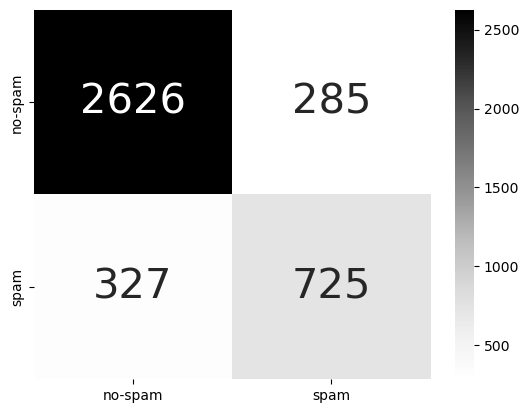

In [19]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [20]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4439 - Train Loss: 1.1972
Val Accuracy: 0.6193 - Val Loss: 1.1184
Validation loss decreased (inf --> 1.118415). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6532 - Train Loss: 0.8445
Val Accuracy: 0.7074 - Val Loss: 0.9531
Validation loss decreased (1.118415 --> 0.953088). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7247 - Train Loss: 0.6673
Val Accuracy: 0.6916 - Val Loss: 0.9192
Validation loss decreased (0.953088 --> 0.919184). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7561 - Train Loss: 0.5565
Val Accuracy: 0.7294 - Val Loss: 0.8758
Validation loss decreased (0.919184 --> 0.875824). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7950 - Train

In [21]:
save_visualization_history(history, 'TextCNN_CustBias', task=2)
plotting_history(history)


In [22]:
import os
import torch

model_name = "TextCNN_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8072
Precision: 0.6116
Recall: 0.6684
F1-score: 0.6297
Confusion matrix:
 [[2541   40  216  114]
 [  18   30    4    2]
 [ 103    3  187   16]
 [ 206    9   33  441]]
              precision    recall  f1-score   support

           0     0.8860    0.8729    0.8794      2911
           1     0.3659    0.5556    0.4412        54
           2     0.4250    0.6052    0.4993       309
           3     0.7696    0.6401    0.6989       689

    accuracy                         0.8072      3963
   macro avg     0.6116    0.6684    0.6297      3963
weighted avg     0.8227    0.8072    0.8124      3963



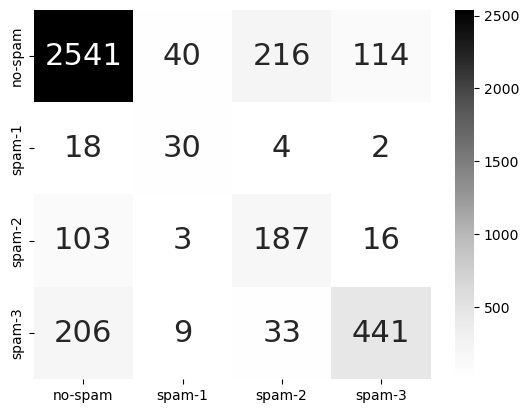

In [23]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Basis Cust Bias

## Task 1

In [24]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7487 - Train Loss: 0.5773
Val Accuracy: 0.8169 - Val Loss: 0.4836
Validation loss decreased (inf --> 0.483555). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8154 - Train Loss: 0.4292
Val Accuracy: 0.8232 - Val Loss: 0.4395
Validation loss decreased (0.483555 --> 0.439507). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8482 - Train Loss: 0.3626
Val Accuracy: 0.8269 - Val Loss: 0.4280
Validation loss decreased (0.439507 --> 0.428050). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8770 - Train Loss: 0.2988
Val Accuracy: 0.8427 - Val Loss: 0.4381
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9018 - Train Loss: 0.2457
Val Accuracy: 0.846

In [25]:
save_visualization_history(history, 'TextCNN_BasisCustBias', task=1)
plotting_history(history)


In [26]:
import os
import torch

model_name = "TextCNN_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8443
Precision: 0.8003
Recall: 0.8008
F1-score: 0.8006
Confusion matrix:
 [[2601  310]
 [ 307  745]]
              precision    recall  f1-score   support

           0     0.8944    0.8935    0.8940      2911
           1     0.7062    0.7082    0.7072      1052

    accuracy                         0.8443      3963
   macro avg     0.8003    0.8008    0.8006      3963
weighted avg     0.8445    0.8443    0.8444      3963



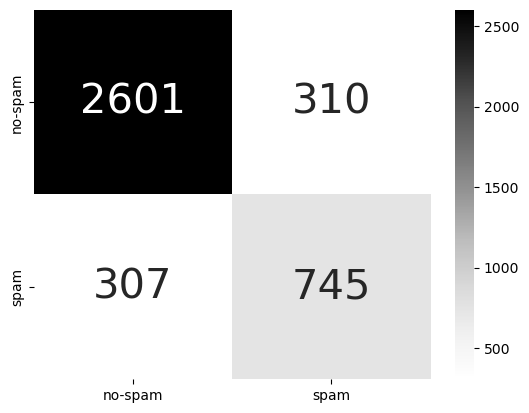

In [27]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [28]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4959 - Train Loss: 1.1677
Val Accuracy: 0.6362 - Val Loss: 1.1187
Validation loss decreased (inf --> 1.118720). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6512 - Train Loss: 0.8399
Val Accuracy: 0.6614 - Val Loss: 0.9431
Validation loss decreased (1.118720 --> 0.943075). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7168 - Train Loss: 0.6709
Val Accuracy: 0.6614 - Val Loss: 0.8796
Validation loss decreased (0.943075 --> 0.879643). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7559 - Train Loss: 0.5572
Val Accuracy: 0.7124 - Val Loss: 0.8901
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7912 - Train Loss: 0.4536
Val Accuracy: 0.726

In [29]:
save_visualization_history(history, 'TextCNN_BasisCustBias', task=2)
plotting_history(history)


In [30]:
import os
import torch

model_name = "TextCNN_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8138
Precision: 0.6287
Recall: 0.6585
F1-score: 0.6365
Confusion matrix:
 [[2568   29  213  101]
 [  20   27    5    2]
 [ 104    2  189   14]
 [ 207    8   33  441]]
              precision    recall  f1-score   support

           0     0.8858    0.8822    0.8840      2911
           1     0.4091    0.5000    0.4500        54
           2     0.4295    0.6117    0.5047       309
           3     0.7903    0.6401    0.7073       689

    accuracy                         0.8138      3963
   macro avg     0.6287    0.6585    0.6365      3963
weighted avg     0.8271    0.8138    0.8178      3963



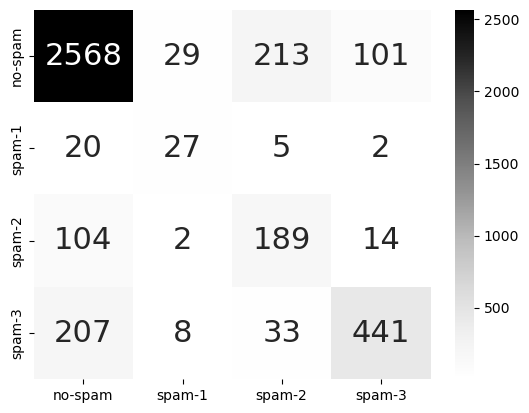

In [31]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Cust Linear

## Task 1

In [32]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6729 - Train Loss: 0.6968
Val Accuracy: 0.7363 - Val Loss: 0.5663
Validation loss decreased (inf --> 0.566313). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7837 - Train Loss: 0.4915
Val Accuracy: 0.7804 - Val Loss: 0.5229
Validation loss decreased (0.566313 --> 0.522860). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8405 - Train Loss: 0.3850
Val Accuracy: 0.7961 - Val Loss: 0.4908
Validation loss decreased (0.522860 --> 0.490762). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8757 - Train Loss: 0.3068
Val Accuracy: 0.8150 - Val Loss: 0.4978
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9058 - Train Loss: 0.2463
Val Accuracy: 0.829

In [33]:
save_visualization_history(history, 'TextCNN_CustLinear', task=1)
plotting_history(history)


In [34]:
import os
import torch

model_name = "TextCNN_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8284
Precision: 0.7839
Recall: 0.7615
F1-score: 0.7713
Confusion matrix:
 [[2632  279]
 [ 401  651]]
              precision    recall  f1-score   support

           0     0.8678    0.9042    0.8856      2911
           1     0.7000    0.6188    0.6569      1052

    accuracy                         0.8284      3963
   macro avg     0.7839    0.7615    0.7713      3963
weighted avg     0.8232    0.8284    0.8249      3963



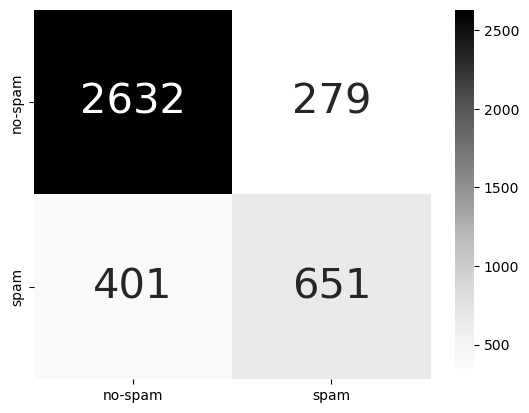

In [35]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [36]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3787 - Train Loss: 1.5118
Val Accuracy: 0.4575 - Val Loss: 1.2393
Validation loss decreased (inf --> 1.239288). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5524 - Train Loss: 0.9750
Val Accuracy: 0.6180 - Val Loss: 1.1894
Validation loss decreased (1.239288 --> 1.189363). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6569 - Train Loss: 0.7621
Val Accuracy: 0.6268 - Val Loss: 1.1642
Validation loss decreased (1.189363 --> 1.164215). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7245 - Train Loss: 0.5852
Val Accuracy: 0.6702 - Val Loss: 1.1469
Validation loss decreased (1.164215 --> 1.146865). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7804 - Train

In [37]:
save_visualization_history(history, 'TextCNN_CustLinear', task=2)
plotting_history(history)


In [38]:
import os
import torch

model_name = "TextCNN_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7840
Precision: 0.5625
Recall: 0.5818
F1-score: 0.5659
Confusion matrix:
 [[2518   29  241  123]
 [  22   20    5    7]
 [ 147    1  149   12]
 [ 197   17   55  420]]
              precision    recall  f1-score   support

           0     0.8731    0.8650    0.8690      2911
           1     0.2985    0.3704    0.3306        54
           2     0.3311    0.4822    0.3926       309
           3     0.7473    0.6096    0.6715       689

    accuracy                         0.7840      3963
   macro avg     0.5625    0.5818    0.5659      3963
weighted avg     0.8011    0.7840    0.7902      3963



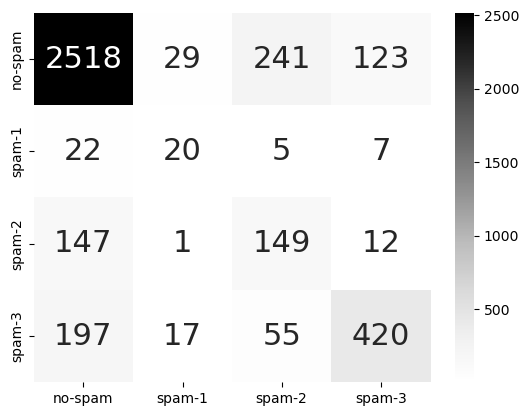

In [39]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Basis Cust Linear

## Task 1

In [40]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7566 - Train Loss: 0.5499
Val Accuracy: 0.8339 - Val Loss: 0.4899
Validation loss decreased (inf --> 0.489927). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8199 - Train Loss: 0.4183
Val Accuracy: 0.8307 - Val Loss: 0.4385
Validation loss decreased (0.489927 --> 0.438528). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8521 - Train Loss: 0.3520
Val Accuracy: 0.8345 - Val Loss: 0.4377
Validation loss decreased (0.438528 --> 0.437656). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8785 - Train Loss: 0.2926
Val Accuracy: 0.8477 - Val Loss: 0.4326
Validation loss decreased (0.437656 --> 0.432628). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9072 - Train

In [41]:
save_visualization_history(history, 'TextCNN_BasisCustLinear', task=1)
plotting_history(history)


In [42]:
import os
import torch

model_name = "TextCNN_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8453
Precision: 0.8027
Recall: 0.7973
F1-score: 0.7999
Confusion matrix:
 [[2619  292]
 [ 321  731]]
              precision    recall  f1-score   support

           0     0.8908    0.8997    0.8952      2911
           1     0.7146    0.6949    0.7046      1052

    accuracy                         0.8453      3963
   macro avg     0.8027    0.7973    0.7999      3963
weighted avg     0.8440    0.8453    0.8446      3963



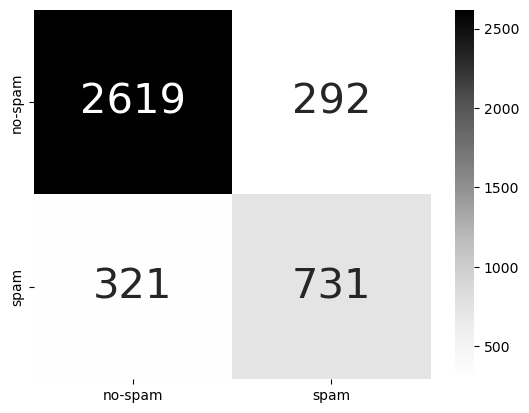

In [43]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [44]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.5597 - Train Loss: 1.0735
Val Accuracy: 0.7067 - Val Loss: 1.0177
Validation loss decreased (inf --> 1.017726). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6974 - Train Loss: 0.7691
Val Accuracy: 0.7086 - Val Loss: 0.8695
Validation loss decreased (1.017726 --> 0.869502). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7445 - Train Loss: 0.5923
Val Accuracy: 0.7206 - Val Loss: 0.8439
Validation loss decreased (0.869502 --> 0.843940). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7861 - Train Loss: 0.4787
Val Accuracy: 0.7338 - Val Loss: 0.8434
Validation loss decreased (0.843940 --> 0.843436). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8218 - Train

In [45]:
save_visualization_history(history, 'TextCNN_BasisCustLinear', task=2)
plotting_history(history)


In [46]:
import os
import torch

model_name = "TextCNN_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8133
Precision: 0.6231
Recall: 0.6792
F1-score: 0.6445
Confusion matrix:
 [[2505   30  234  142]
 [  19   27    3    5]
 [  92    1  198   18]
 [ 158    7   31  493]]
              precision    recall  f1-score   support

           0     0.9030    0.8605    0.8813      2911
           1     0.4154    0.5000    0.4538        54
           2     0.4249    0.6408    0.5110       309
           3     0.7492    0.7155    0.7320       689

    accuracy                         0.8133      3963
   macro avg     0.6231    0.6792    0.6445      3963
weighted avg     0.8324    0.8133    0.8206      3963



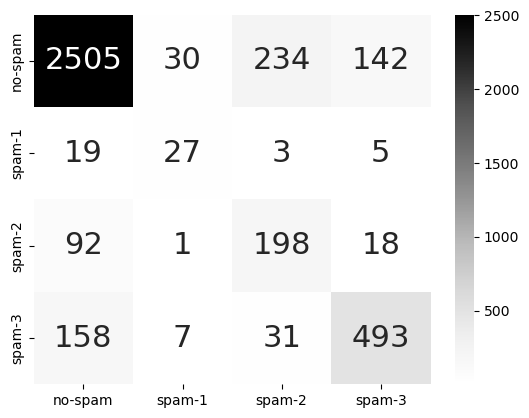

In [47]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Cust Word Embedding

## Task 1

In [48]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6799 - Train Loss: 0.6262
Val Accuracy: 0.8112 - Val Loss: 0.5728
Validation loss decreased (inf --> 0.572847). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7931 - Train Loss: 0.4788
Val Accuracy: 0.8269 - Val Loss: 0.5333
Validation loss decreased (0.572847 --> 0.533319). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8504 - Train Loss: 0.3644
Val Accuracy: 0.8307 - Val Loss: 0.5186
Validation loss decreased (0.533319 --> 0.518615). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8917 - Train Loss: 0.2719
Val Accuracy: 0.8414 - Val Loss: 0.6115
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9273 - Train Loss: 0.1959
Val Accuracy: 0.834

In [49]:
save_visualization_history(history, 'TextCNN_CustWordEmbedding', task=1)
plotting_history(history)


In [50]:
import os
import torch

model_name = "TextCNN_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8282
Precision: 0.7973
Recall: 0.7337
F1-score: 0.7553
Confusion matrix:
 [[2722  189]
 [ 492  560]]
              precision    recall  f1-score   support

           0     0.8469    0.9351    0.8888      2911
           1     0.7477    0.5323    0.6219      1052

    accuracy                         0.8282      3963
   macro avg     0.7973    0.7337    0.7553      3963
weighted avg     0.8206    0.8282    0.8180      3963



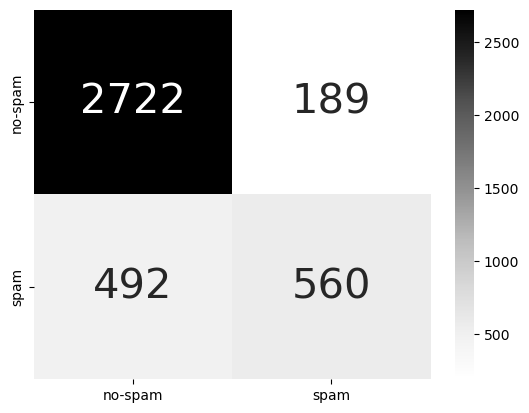

In [51]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [52]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_CustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4277 - Train Loss: 1.2526
Val Accuracy: 0.5249 - Val Loss: 1.1891
Validation loss decreased (inf --> 1.189123). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6073 - Train Loss: 0.9358
Val Accuracy: 0.6665 - Val Loss: 1.0962
Validation loss decreased (1.189123 --> 1.096217). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7118 - Train Loss: 0.6874
Val Accuracy: 0.7244 - Val Loss: 1.0994
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7747 - Train Loss: 0.4884
Val Accuracy: 0.7451 - Val Loss: 1.1529
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8290 - Train Loss: 0.3431
Val Accuracy: 0.7351 - Val Loss: 1.2498
EarlyStoppin

In [53]:
save_visualization_history(history, 'TextCNN_CustWordEmbedding', task=2)
plotting_history(history)


In [54]:
import os
import torch

model_name = "TextCNN_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7812
Precision: 0.5539
Recall: 0.5719
F1-score: 0.5439
Confusion matrix:
 [[2595   34  193   89]
 [  24   23    6    1]
 [ 141    3  155   10]
 [ 243   38   85  323]]
              precision    recall  f1-score   support

           0     0.8641    0.8914    0.8776      2911
           1     0.2347    0.4259    0.3026        54
           2     0.3531    0.5016    0.4144       309
           3     0.7636    0.4688    0.5809       689

    accuracy                         0.7812      3963
   macro avg     0.5539    0.5719    0.5439      3963
weighted avg     0.7982    0.7812    0.7821      3963



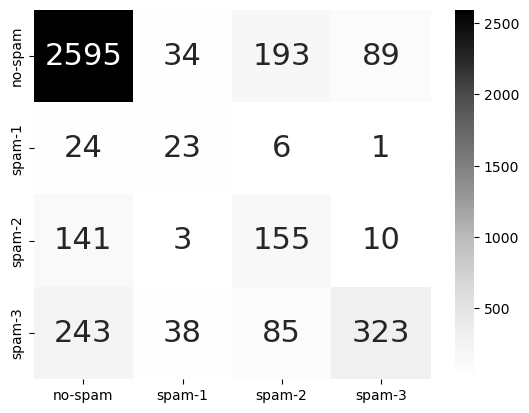

In [55]:
plotting_confusion_matrix(test_cm, task=2)


# TextCNN - Basis Cust Word Embedding

## Task 1

In [56]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7657 - Train Loss: 0.5513
Val Accuracy: 0.8257 - Val Loss: 0.5190
Validation loss decreased (inf --> 0.519037). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8339 - Train Loss: 0.3992
Val Accuracy: 0.8376 - Val Loss: 0.4761
Validation loss decreased (0.519037 --> 0.476139). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8858 - Train Loss: 0.2885
Val Accuracy: 0.8383 - Val Loss: 0.4855
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.9212 - Train Loss: 0.2045
Val Accuracy: 0.8213 - Val Loss: 0.5003
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9394 - Train Loss: 0.1521
Val Accuracy: 0.8364 - Val Loss: 0.5949
EarlyStoppin

In [57]:
save_visualization_history(history, 'TextCNN_BasisCustWordEmbedding', task=1)
plotting_history(history)


In [58]:
import os
import torch

model_name = "TextCNN_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8337
Precision: 0.7858
Recall: 0.7958
F1-score: 0.7905
Confusion matrix:
 [[2552  359]
 [ 300  752]]
              precision    recall  f1-score   support

           0     0.8948    0.8767    0.8856      2911
           1     0.6769    0.7148    0.6953      1052

    accuracy                         0.8337      3963
   macro avg     0.7858    0.7958    0.7905      3963
weighted avg     0.8370    0.8337    0.8351      3963



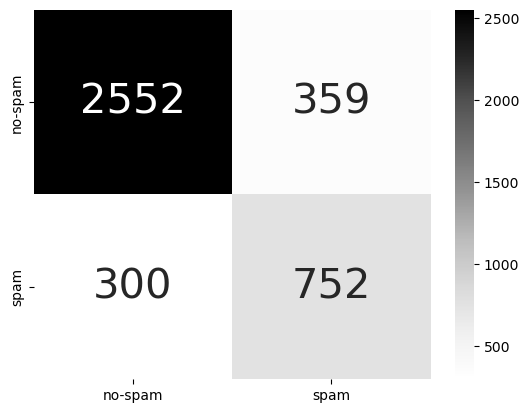

In [59]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [60]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="TextCNN_BasisCustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.5783 - Train Loss: 1.0548
Val Accuracy: 0.6117 - Val Loss: 0.9862
Validation loss decreased (inf --> 0.986211). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7058 - Train Loss: 0.7103
Val Accuracy: 0.6822 - Val Loss: 0.8818
Validation loss decreased (0.986211 --> 0.881843). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7808 - Train Loss: 0.5139
Val Accuracy: 0.7546 - Val Loss: 0.9472
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8386 - Train Loss: 0.3477
Val Accuracy: 0.8081 - Val Loss: 1.1307
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8838 - Train Loss: 0.2321
Val Accuracy: 0.7470 - Val Loss: 1.1042
EarlyStoppin

In [61]:
save_visualization_history(history, 'TextCNN_BasisCustWordEmbedding', task=2)
plotting_history(history)


In [62]:
import os
import torch

model_name = "TextCNN_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7926
Precision: 0.5761
Recall: 0.5968
F1-score: 0.5615
Confusion matrix:
 [[2651   24  147   89]
 [  20   28    3    3]
 [ 137    2  161    9]
 [ 289   69   30  301]]
              precision    recall  f1-score   support

           0     0.8560    0.9107    0.8825      2911
           1     0.2276    0.5185    0.3164        54
           2     0.4721    0.5210    0.4954       309
           3     0.7488    0.4369    0.5518       689

    accuracy                         0.7926      3963
   macro avg     0.5761    0.5968    0.5615      3963
weighted avg     0.7989    0.7926    0.7871      3963



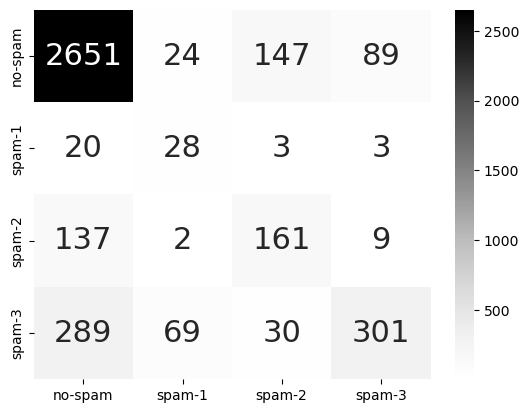

In [63]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Cust Bias

## Task 1

In [64]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6539 - Train Loss: 0.6189
Val Accuracy: 0.7565 - Val Loss: 0.4935
Validation loss decreased (inf --> 0.493459). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7905 - Train Loss: 0.4533
Val Accuracy: 0.8137 - Val Loss: 0.4443
Validation loss decreased (0.493459 --> 0.444267). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8328 - Train Loss: 0.3825
Val Accuracy: 0.8395 - Val Loss: 0.4520
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8598 - Train Loss: 0.3273
Val Accuracy: 0.8188 - Val Loss: 0.4498
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8867 - Train Loss: 0.2753
Val Accuracy: 0.8458 - Val Loss: 0.4619
EarlyStoppin

In [65]:
save_visualization_history(history, 'BiLSTM_CustBias', task=1)
plotting_history(history)


In [66]:
import os
import torch

model_name = "BiLSTM_CustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8448
Precision: 0.8087
Recall: 0.7781
F1-score: 0.7911
Confusion matrix:
 [[2679  232]
 [ 383  669]]
              precision    recall  f1-score   support

           0     0.8749    0.9203    0.8970      2911
           1     0.7425    0.6359    0.6851      1052

    accuracy                         0.8448      3963
   macro avg     0.8087    0.7781    0.7911      3963
weighted avg     0.8398    0.8448    0.8408      3963



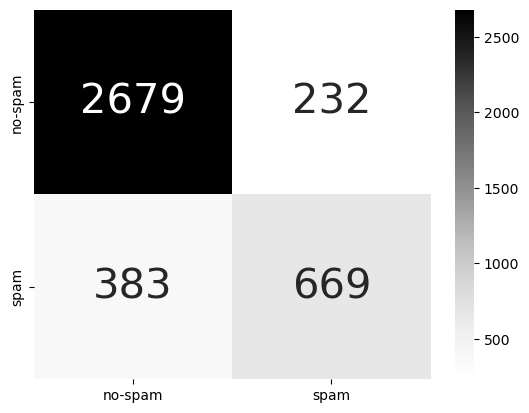

In [67]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [68]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3695 - Train Loss: 1.2861
Val Accuracy: 0.4330 - Val Loss: 1.1841
Validation loss decreased (inf --> 1.184089). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5686 - Train Loss: 0.9182
Val Accuracy: 0.6136 - Val Loss: 0.9422
Validation loss decreased (1.184089 --> 0.942210). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6736 - Train Loss: 0.7055
Val Accuracy: 0.7275 - Val Loss: 0.8826
Validation loss decreased (0.942210 --> 0.882616). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7182 - Train Loss: 0.6411
Val Accuracy: 0.7093 - Val Loss: 0.8575
Validation loss decreased (0.882616 --> 0.857492). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7781 - Train

In [69]:
save_visualization_history(history, 'BiLSTM_CustBias', task=2)
plotting_history(history)


In [70]:
import os
import torch

model_name = "BiLSTM_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7868
Precision: 0.5931
Recall: 0.6811
F1-score: 0.6232
Confusion matrix:
 [[2401   32  303  175]
 [  16   29    4    5]
 [  95    1  204    9]
 [ 151   14   40  484]]
              precision    recall  f1-score   support

           0     0.9016    0.8248    0.8615      2911
           1     0.3816    0.5370    0.4462        54
           2     0.3702    0.6602    0.4744       309
           3     0.7192    0.7025    0.7107       689

    accuracy                         0.7868      3963
   macro avg     0.5931    0.6811    0.6232      3963
weighted avg     0.8214    0.7868    0.7994      3963



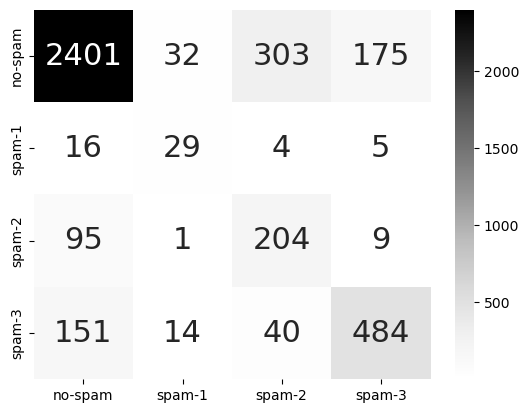

In [71]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Basis Cust Bias

## Task 1

In [72]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6957 - Train Loss: 0.6078
Val Accuracy: 0.7703 - Val Loss: 0.4837
Validation loss decreased (inf --> 0.483723). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7982 - Train Loss: 0.4561
Val Accuracy: 0.8238 - Val Loss: 0.4464
Validation loss decreased (0.483723 --> 0.446424). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8362 - Train Loss: 0.3824
Val Accuracy: 0.8383 - Val Loss: 0.4374
Validation loss decreased (0.446424 --> 0.437406). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8631 - Train Loss: 0.3298
Val Accuracy: 0.8087 - Val Loss: 0.4332
Validation loss decreased (0.437406 --> 0.433171). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8862 - Train

In [73]:
save_visualization_history(history, 'BiLSTM_BasisCustBias', task=1)
plotting_history(history)


In [74]:
import os
import torch

model_name = "BiLSTM_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8367
Precision: 0.7906
Recall: 0.7914
F1-score: 0.7910
Confusion matrix:
 [[2585  326]
 [ 321  731]]
              precision    recall  f1-score   support

           0     0.8895    0.8880    0.8888      2911
           1     0.6916    0.6949    0.6932      1052

    accuracy                         0.8367      3963
   macro avg     0.7906    0.7914    0.7910      3963
weighted avg     0.8370    0.8367    0.8369      3963



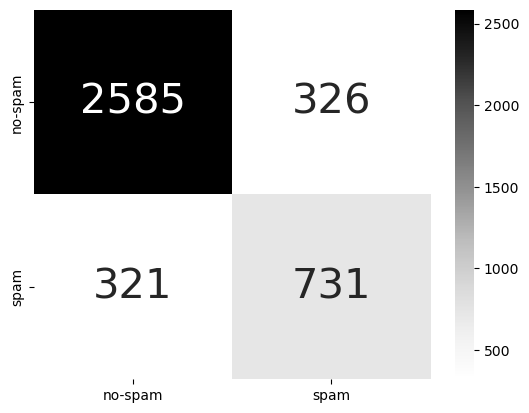

In [75]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [76]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3264 - Train Loss: 1.2823
Val Accuracy: 0.6778 - Val Loss: 1.1500
Validation loss decreased (inf --> 1.149954). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5844 - Train Loss: 0.9146
Val Accuracy: 0.6149 - Val Loss: 0.9231
Validation loss decreased (1.149954 --> 0.923084). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6841 - Train Loss: 0.7156
Val Accuracy: 0.6986 - Val Loss: 0.8735
Validation loss decreased (0.923084 --> 0.873525). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7277 - Train Loss: 0.5970
Val Accuracy: 0.7080 - Val Loss: 0.8411
Validation loss decreased (0.873525 --> 0.841102). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7532 - Train

In [77]:
save_visualization_history(history, 'BiLSTM_BasisCustBias', task=2)
plotting_history(history)


In [78]:
import os
import torch

model_name = "BiLSTM_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7848
Precision: 0.5836
Recall: 0.6836
F1-score: 0.6097
Confusion matrix:
 [[2393   47  353  118]
 [  17   29    6    2]
 [  87    3  211    8]
 [ 147   18   47  477]]
              precision    recall  f1-score   support

           0     0.9051    0.8221    0.8616      2911
           1     0.2990    0.5370    0.3841        54
           2     0.3420    0.6828    0.4557       309
           3     0.7884    0.6923    0.7372       689

    accuracy                         0.7848      3963
   macro avg     0.5836    0.6836    0.6097      3963
weighted avg     0.8326    0.7848    0.8018      3963



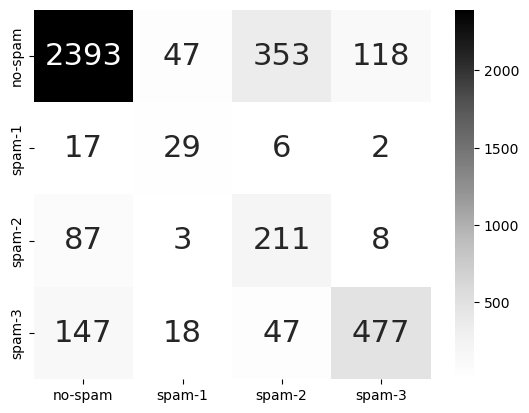

In [79]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Cust Linear

## Task 1

In [80]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6385 - Train Loss: 0.6556
Val Accuracy: 0.7300 - Val Loss: 0.5264
Validation loss decreased (inf --> 0.526357). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7672 - Train Loss: 0.4947
Val Accuracy: 0.7671 - Val Loss: 0.4750
Validation loss decreased (0.526357 --> 0.475040). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8073 - Train Loss: 0.4262
Val Accuracy: 0.7999 - Val Loss: 0.4500
Validation loss decreased (0.475040 --> 0.450025). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8444 - Train Loss: 0.3659
Val Accuracy: 0.8244 - Val Loss: 0.4387
Validation loss decreased (0.450025 --> 0.438703). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8701 - Train

In [81]:
save_visualization_history(history, 'BiLSTM_CustLinear', task=1)
plotting_history(history)


In [82]:
import os
import torch

model_name = "BiLSTM_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8428
Precision: 0.8002
Recall: 0.7910
F1-score: 0.7954
Confusion matrix:
 [[2624  287]
 [ 336  716]]
              precision    recall  f1-score   support

           0     0.8865    0.9014    0.8939      2911
           1     0.7139    0.6806    0.6968      1052

    accuracy                         0.8428      3963
   macro avg     0.8002    0.7910    0.7954      3963
weighted avg     0.8407    0.8428    0.8416      3963



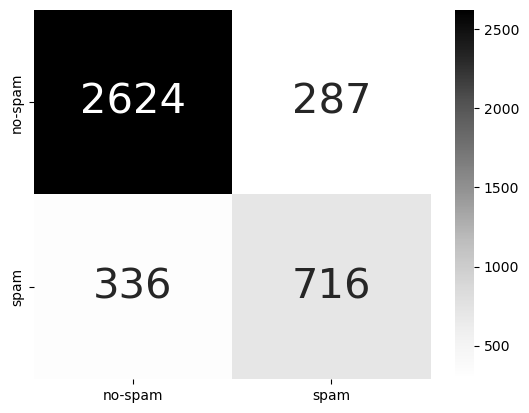

In [83]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [84]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3573 - Train Loss: 1.4132
Val Accuracy: 0.4884 - Val Loss: 1.2653
Validation loss decreased (inf --> 1.265340). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.5020 - Train Loss: 1.0723
Val Accuracy: 0.5053 - Val Loss: 1.1503
Validation loss decreased (1.265340 --> 1.150295). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.5995 - Train Loss: 0.8696
Val Accuracy: 0.5777 - Val Loss: 1.0839
Validation loss decreased (1.150295 --> 1.083915). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.6667 - Train Loss: 0.7179
Val Accuracy: 0.6444 - Val Loss: 1.0716
Validation loss decreased (1.083915 --> 1.071590). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7274 - Train

In [85]:
save_visualization_history(history, 'BiLSTM_CustLinear', task=2)
plotting_history(history)


In [86]:
import os
import torch

model_name = "BiLSTM_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7757
Precision: 0.5631
Recall: 0.6351
F1-score: 0.5802
Confusion matrix:
 [[2418   48  323  122]
 [  19   24    7    4]
 [ 103    2  195    9]
 [ 178   17   57  437]]
              precision    recall  f1-score   support

           0     0.8896    0.8306    0.8591      2911
           1     0.2637    0.4444    0.3310        54
           2     0.3351    0.6311    0.4377       309
           3     0.7640    0.6343    0.6931       689

    accuracy                         0.7757      3963
   macro avg     0.5631    0.6351    0.5802      3963
weighted avg     0.8160    0.7757    0.7902      3963



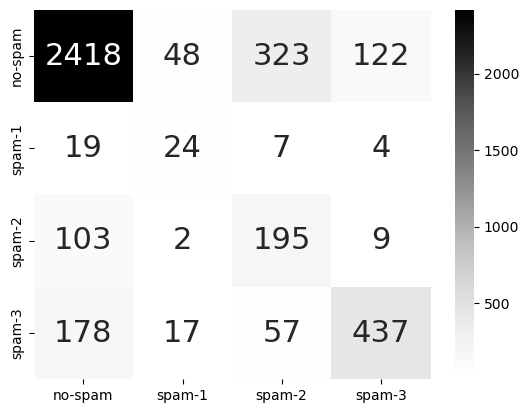

In [87]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Basis Cust Linear

## Task 1

In [88]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7045 - Train Loss: 0.5754
Val Accuracy: 0.7382 - Val Loss: 0.4823
Validation loss decreased (inf --> 0.482321). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8017 - Train Loss: 0.4350
Val Accuracy: 0.8162 - Val Loss: 0.4315
Validation loss decreased (0.482321 --> 0.431498). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8349 - Train Loss: 0.3766
Val Accuracy: 0.8464 - Val Loss: 0.4410
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8682 - Train Loss: 0.3190
Val Accuracy: 0.8099 - Val Loss: 0.4303
Validation loss decreased (0.431498 --> 0.430295). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8862 - Train Loss: 0.2711
Val Accuracy: 0.847

In [89]:
save_visualization_history(history, 'BiLSTM_BasisCustLinear', task=1)
plotting_history(history)


In [90]:
import os
import torch

model_name="BiLSTM_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8486
Precision: 0.8112
Recall: 0.7892
F1-score: 0.7990
Confusion matrix:
 [[2666  245]
 [ 355  697]]
              precision    recall  f1-score   support

           0     0.8825    0.9158    0.8989      2911
           1     0.7399    0.6625    0.6991      1052

    accuracy                         0.8486      3963
   macro avg     0.8112    0.7892    0.7990      3963
weighted avg     0.8446    0.8486    0.8458      3963



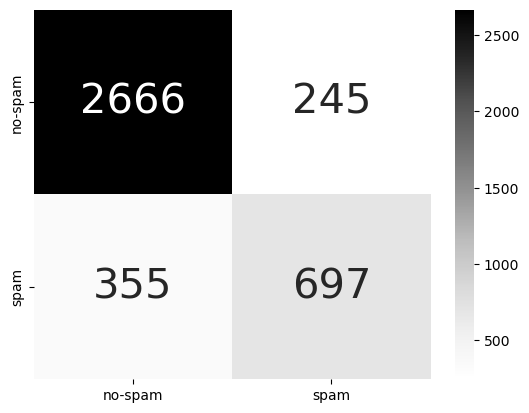

In [91]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [92]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4893 - Train Loss: 1.1028
Val Accuracy: 0.6784 - Val Loss: 1.0406
Validation loss decreased (inf --> 1.040649). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6511 - Train Loss: 0.7775
Val Accuracy: 0.7256 - Val Loss: 0.9827
Validation loss decreased (1.040649 --> 0.982721). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7092 - Train Loss: 0.6508
Val Accuracy: 0.6841 - Val Loss: 0.9610
Validation loss decreased (0.982721 --> 0.960982). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7601 - Train Loss: 0.5375
Val Accuracy: 0.7596 - Val Loss: 0.9820
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7852 - Train Loss: 0.4400
Val Accuracy: 0.773

In [93]:
save_visualization_history(history, 'BiLSTM_BasisCustLinear', task=2)
plotting_history(history)


In [94]:
import os
import torch

model_name="BiLSTM_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7726
Precision: 0.5855
Recall: 0.6825
F1-score: 0.6044
Confusion matrix:
 [[2407   45  349  110]
 [  14   33    5    2]
 [  82    2  218    7]
 [ 190   17   78  404]]
              precision    recall  f1-score   support

           0     0.8938    0.8269    0.8590      2911
           1     0.3402    0.6111    0.4371        54
           2     0.3354    0.7055    0.4546       309
           3     0.7725    0.5864    0.6667       689

    accuracy                         0.7726      3963
   macro avg     0.5855    0.6825    0.6044      3963
weighted avg     0.8216    0.7726    0.7883      3963



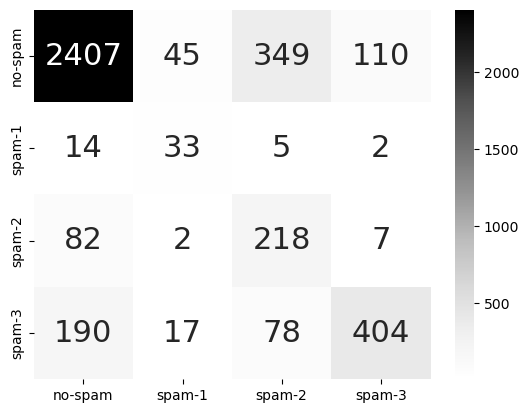

In [95]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Cust Word Embedding

## Task 1

In [96]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6656 - Train Loss: 0.6519
Val Accuracy: 0.6891 - Val Loss: 0.5736
Validation loss decreased (inf --> 0.573551). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7525 - Train Loss: 0.5243
Val Accuracy: 0.8181 - Val Loss: 0.4897
Validation loss decreased (0.573551 --> 0.489720). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8249 - Train Loss: 0.4032
Val Accuracy: 0.8357 - Val Loss: 0.5026
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8754 - Train Loss: 0.3088
Val Accuracy: 0.8364 - Val Loss: 0.5166
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9084 - Train Loss: 0.2322
Val Accuracy: 0.8414 - Val Loss: 0.6732
EarlyStoppin

In [97]:
save_visualization_history(history, 'BiLSTM_CustWordEmbedding', task=1)
plotting_history(history)


In [98]:
import os
import torch

model_name="BiLSTM_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8292
Precision: 0.7907
Recall: 0.7483
F1-score: 0.7647
Confusion matrix:
 [[2680  231]
 [ 446  606]]
              precision    recall  f1-score   support

           0     0.8573    0.9206    0.8879      2911
           1     0.7240    0.5760    0.6416      1052

    accuracy                         0.8292      3963
   macro avg     0.7907    0.7483    0.7647      3963
weighted avg     0.8219    0.8292    0.8225      3963



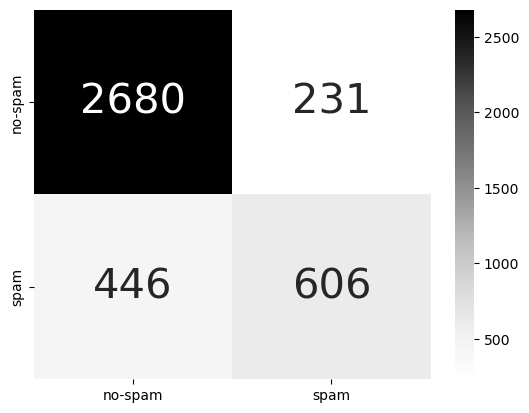

In [99]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [100]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_CustWordEmbedding", task=2).to(device)
print(model)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
ViSpam_Classifier(
  (embedding): CustWordEmbedding(
    (embedding): Embedding(17196, 300, padding_idx=0)
    (category_id): Embedding(12, 90000)
  )
  (spatial_dropout1d): Dropout2d(p=0.5, inplace=False)
  (network): BiLSTM(
    (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  )
  (W): BasicLinear(
    (W): Linear(in_features=256, out_features=4, bias=False)
  )
  (bias): BasicBias()
)
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3321 - Train Loss: 1.3354
Val Accuracy: 0.4676 - Val Loss: 1.2802
Validation loss decreased (inf --> 1.280198). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.4343 - Train Loss: 1.1766
Val Accuracy: 0.4896 - Val Loss: 1.1658
Validation loss decreased (1.280198 --> 1.165820). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.5571 - Train Loss: 0.9451
Val Accura

In [101]:
save_visualization_history(history, 'BiLSTM_CustWordEmbedding', task=2)
plotting_history(history)


In [102]:
import os
import torch

model_name="BiLSTM_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7701
Precision: 0.5506
Recall: 0.5981
F1-score: 0.5489
Confusion matrix:
 [[2515   44  262   90]
 [  19   26    6    3]
 [ 126    3  171    9]
 [ 257   46   46  340]]
              precision    recall  f1-score   support

           0     0.8622    0.8640    0.8631      2911
           1     0.2185    0.4815    0.3006        54
           2     0.3526    0.5534    0.4307       309
           3     0.7692    0.4935    0.6012       689

    accuracy                         0.7701      3963
   macro avg     0.5506    0.5981    0.5489      3963
weighted avg     0.7975    0.7701    0.7762      3963



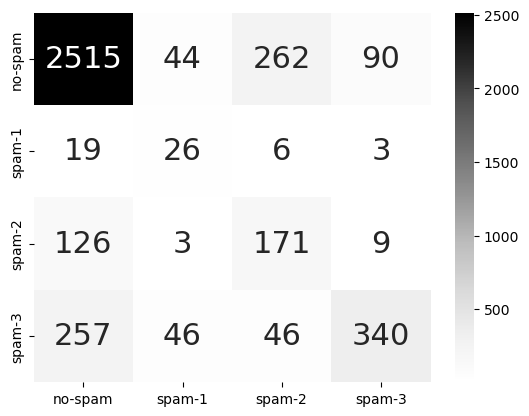

In [103]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM - Basis Cust Word Embedding

## Task 1

In [104]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7777 - Train Loss: 0.5757
Val Accuracy: 0.8074 - Val Loss: 0.4916
Validation loss decreased (inf --> 0.491644). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8203 - Train Loss: 0.4102
Val Accuracy: 0.8169 - Val Loss: 0.4457
Validation loss decreased (0.491644 --> 0.445734). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8734 - Train Loss: 0.3123
Val Accuracy: 0.8288 - Val Loss: 0.4491
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.9086 - Train Loss: 0.2336
Val Accuracy: 0.8037 - Val Loss: 0.4977
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9318 - Train Loss: 0.1785
Val Accuracy: 0.8370 - Val Loss: 0.6154
EarlyStoppin

In [105]:
save_visualization_history(history, 'BiLSTM_BasisCustWordEmbedding', task=1)
plotting_history(history)


In [106]:
import os
import torch

model_name="BiLSTM_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8362
Precision: 0.7920
Recall: 0.7805
F1-score: 0.7859
Confusion matrix:
 [[2618  293]
 [ 356  696]]
              precision    recall  f1-score   support

           0     0.8803    0.8993    0.8897      2911
           1     0.7037    0.6616    0.6820      1052

    accuracy                         0.8362      3963
   macro avg     0.7920    0.7805    0.7859      3963
weighted avg     0.8334    0.8362    0.8346      3963



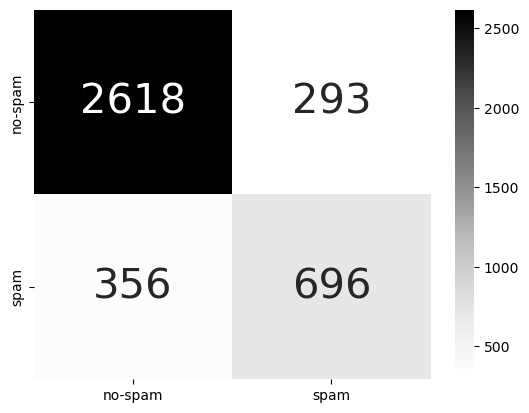

In [107]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [108]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiLSTM_BasisCustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4590 - Train Loss: 1.2066
Val Accuracy: 0.5972 - Val Loss: 1.0547
Validation loss decreased (inf --> 1.054650). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6297 - Train Loss: 0.8158
Val Accuracy: 0.6790 - Val Loss: 0.8648
Validation loss decreased (1.054650 --> 0.864756). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7375 - Train Loss: 0.5836
Val Accuracy: 0.7162 - Val Loss: 0.8027
Validation loss decreased (0.864756 --> 0.802653). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8036 - Train Loss: 0.4036
Val Accuracy: 0.7413 - Val Loss: 0.8412
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8517 - Train Loss: 0.3087
Val Accuracy: 0.761

In [109]:
save_visualization_history(history, 'BiLSTM_BasisCustWordEmbedding', task=2)
plotting_history(history)


In [110]:
import os
import torch

model_name="BiLSTM_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7921
Precision: 0.5738
Recall: 0.6876
F1-score: 0.6106
Confusion matrix:
 [[2425   51  269  166]
 [  16   33    2    3]
 [ 109    2  178   20]
 [ 132   28   26  503]]
              precision    recall  f1-score   support

           0     0.9042    0.8330    0.8672      2911
           1     0.2895    0.6111    0.3929        54
           2     0.3747    0.5761    0.4541       309
           3     0.7269    0.7300    0.7285       689

    accuracy                         0.7921      3963
   macro avg     0.5738    0.6876    0.6106      3963
weighted avg     0.8237    0.7921    0.8044      3963



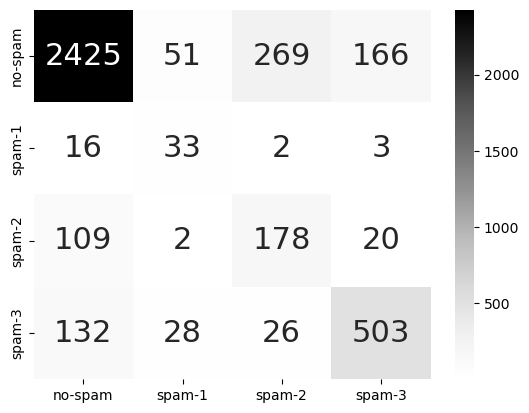

In [111]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Cust Bias

## Task 1

In [112]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6935 - Train Loss: 0.5972
Val Accuracy: 0.7678 - Val Loss: 0.4788
Validation loss decreased (inf --> 0.478846). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8033 - Train Loss: 0.4424
Val Accuracy: 0.8276 - Val Loss: 0.4429
Validation loss decreased (0.478846 --> 0.442880). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8412 - Train Loss: 0.3725
Val Accuracy: 0.8383 - Val Loss: 0.4483
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8667 - Train Loss: 0.3196
Val Accuracy: 0.8219 - Val Loss: 0.4453
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8884 - Train Loss: 0.2701
Val Accuracy: 0.8464 - Val Loss: 0.4690
EarlyStoppin

In [113]:
save_visualization_history(history, 'BiGRU_CustBias', task=1)
plotting_history(history)


In [114]:
import os
import torch

model_name="BiGRU_CustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8383
Precision: 0.7921
Recall: 0.7958
F1-score: 0.7939
Confusion matrix:
 [[2580  331]
 [ 310  742]]
              precision    recall  f1-score   support

           0     0.8927    0.8863    0.8895      2911
           1     0.6915    0.7053    0.6984      1052

    accuracy                         0.8383      3963
   macro avg     0.7921    0.7958    0.7939      3963
weighted avg     0.8393    0.8383    0.8388      3963



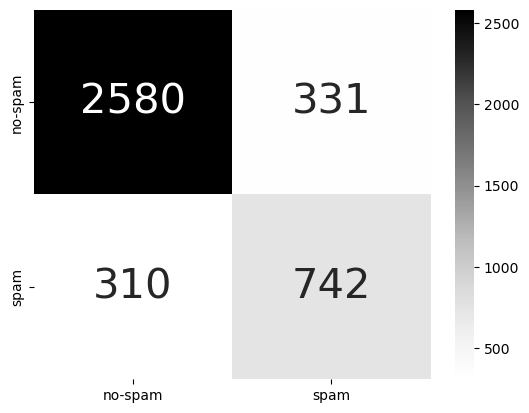

In [115]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [116]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3829 - Train Loss: 1.2630
Val Accuracy: 0.5374 - Val Loss: 1.1334
Validation loss decreased (inf --> 1.133440). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6183 - Train Loss: 0.9004
Val Accuracy: 0.6312 - Val Loss: 0.9655
Validation loss decreased (1.133440 --> 0.965498). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7103 - Train Loss: 0.6592
Val Accuracy: 0.6457 - Val Loss: 0.8994
Validation loss decreased (0.965498 --> 0.899402). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7545 - Train Loss: 0.5344
Val Accuracy: 0.7313 - Val Loss: 0.9285
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7973 - Train Loss: 0.4332
Val Accuracy: 0.749

In [117]:
save_visualization_history(history, 'BiGRU_CustBias', task=2)
plotting_history(history)


In [118]:
import os
import torch

model_name="BiGRU_CustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7815
Precision: 0.5558
Recall: 0.6830
F1-score: 0.5949
Confusion matrix:
 [[2358   82  275  196]
 [  17   30    1    6]
 [ 102    2  189   16]
 [ 123   17   29  520]]
              precision    recall  f1-score   support

           0     0.9069    0.8100    0.8557      2911
           1     0.2290    0.5556    0.3243        54
           2     0.3826    0.6117    0.4707       309
           3     0.7046    0.7547    0.7288       689

    accuracy                         0.7815      3963
   macro avg     0.5558    0.6830    0.5949      3963
weighted avg     0.8216    0.7815    0.7964      3963



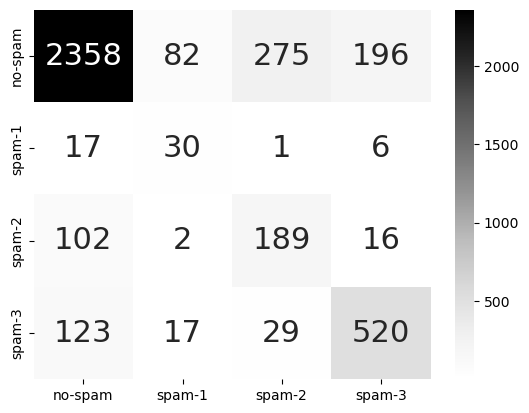

In [119]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Basis Cust Bias

## Task 1

In [120]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustBias", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7070 - Train Loss: 0.5970
Val Accuracy: 0.7948 - Val Loss: 0.4831
Validation loss decreased (inf --> 0.483087). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8036 - Train Loss: 0.4420
Val Accuracy: 0.8118 - Val Loss: 0.4424
Validation loss decreased (0.483087 --> 0.442426). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8426 - Train Loss: 0.3745
Val Accuracy: 0.8219 - Val Loss: 0.4406
Validation loss decreased (0.442426 --> 0.440554). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8698 - Train Loss: 0.3194
Val Accuracy: 0.8376 - Val Loss: 0.4676
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8897 - Train Loss: 0.2718
Val Accuracy: 0.832

In [121]:
save_visualization_history(history, 'BiGRU_BasisCustBias', task=1)
plotting_history(history)


In [122]:
import os
import torch

model_name="BiGRU_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8408
Precision: 0.8007
Recall: 0.7784
F1-score: 0.7882
Confusion matrix:
 [[2653  258]
 [ 373  679]]
              precision    recall  f1-score   support

           0     0.8767    0.9114    0.8937      2911
           1     0.7247    0.6454    0.6828      1052

    accuracy                         0.8408      3963
   macro avg     0.8007    0.7784    0.7882      3963
weighted avg     0.8364    0.8408    0.8377      3963



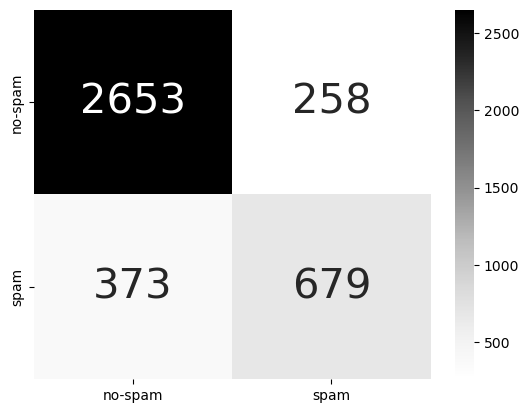

In [123]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [124]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustBias", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4121 - Train Loss: 1.2756
Val Accuracy: 0.5356 - Val Loss: 1.1460
Validation loss decreased (inf --> 1.146031). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6098 - Train Loss: 0.9058
Val Accuracy: 0.6910 - Val Loss: 0.9263
Validation loss decreased (1.146031 --> 0.926334). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7022 - Train Loss: 0.6841
Val Accuracy: 0.7130 - Val Loss: 0.8872
Validation loss decreased (0.926334 --> 0.887222). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7537 - Train Loss: 0.5314
Val Accuracy: 0.7281 - Val Loss: 0.9208
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7932 - Train Loss: 0.4373
Val Accuracy: 0.752

In [125]:
save_visualization_history(history, 'BiGRU_BasisCustBias', task=2)
plotting_history(history)


In [126]:
import os
import torch

model_name="BiGRU_BasisCustBias"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7860
Precision: 0.5778
Recall: 0.6793
F1-score: 0.6087
Confusion matrix:
 [[2394   52  324  141]
 [  18   29    3    4]
 [  96    3  198   12]
 [ 140   13   42  494]]
              precision    recall  f1-score   support

           0     0.9041    0.8224    0.8613      2911
           1     0.2990    0.5370    0.3841        54
           2     0.3492    0.6408    0.4521       309
           3     0.7588    0.7170    0.7373       689

    accuracy                         0.7860      3963
   macro avg     0.5778    0.6793    0.6087      3963
weighted avg     0.8273    0.7860    0.8013      3963



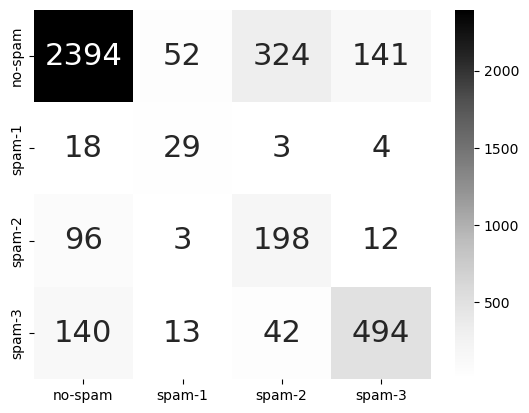

In [127]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Cust Linear

## Task 1

In [128]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6170 - Train Loss: 0.8087
Val Accuracy: 0.7149 - Val Loss: 0.5775
Validation loss decreased (inf --> 0.577525). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7544 - Train Loss: 0.5142
Val Accuracy: 0.7225 - Val Loss: 0.5252
Validation loss decreased (0.577525 --> 0.525203). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8120 - Train Loss: 0.4155
Val Accuracy: 0.7923 - Val Loss: 0.4859
Validation loss decreased (0.525203 --> 0.485937). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8465 - Train Loss: 0.3538
Val Accuracy: 0.8049 - Val Loss: 0.4631
Validation loss decreased (0.485937 --> 0.463111). Saving model ...
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8726 - Train

In [129]:
save_visualization_history(history, 'BiGRU_CustLinear', task=1)
plotting_history(history)


In [130]:
import os
import torch

model_name="BiGRU_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8264
Precision: 0.7800
Recall: 0.7628
F1-score: 0.7706
Confusion matrix:
 [[2615  296]
 [ 392  660]]
              precision    recall  f1-score   support

           0     0.8696    0.8983    0.8837      2911
           1     0.6904    0.6274    0.6574      1052

    accuracy                         0.8264      3963
   macro avg     0.7800    0.7628    0.7706      3963
weighted avg     0.8221    0.8264    0.8237      3963



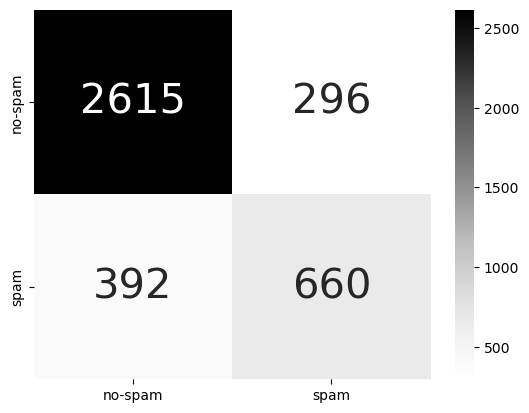

In [131]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [132]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustLinear", task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3211 - Train Loss: 1.7239
Val Accuracy: 0.5079 - Val Loss: 1.4238
Validation loss decreased (inf --> 1.423789). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.4994 - Train Loss: 1.0874
Val Accuracy: 0.5828 - Val Loss: 1.2247
Validation loss decreased (1.423789 --> 1.224733). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.6152 - Train Loss: 0.8238
Val Accuracy: 0.6394 - Val Loss: 1.1188
Validation loss decreased (1.224733 --> 1.118802). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.6834 - Train Loss: 0.6780
Val Accuracy: 0.6595 - Val Loss: 1.1241
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7293 - Train Loss: 0.5475
Val Accuracy: 0.703

In [133]:
save_visualization_history(history, 'BiGRU_CustLinear', task=2)
plotting_history(history)


In [134]:
import os
import torch

model_name="BiGRU_CustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7608
Precision: 0.5390
Recall: 0.6019
F1-score: 0.5516
Confusion matrix:
 [[2421   55  303  132]
 [  19   23    5    7]
 [ 118    3  180    8]
 [ 216   19   63  391]]
              precision    recall  f1-score   support

           0     0.8727    0.8317    0.8517      2911
           1     0.2300    0.4259    0.2987        54
           2     0.3267    0.5825    0.4186       309
           3     0.7268    0.5675    0.6373       689

    accuracy                         0.7608      3963
   macro avg     0.5390    0.6019    0.5516      3963
weighted avg     0.7960    0.7608    0.7731      3963



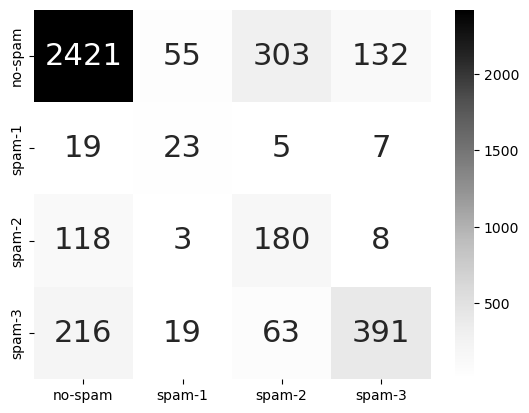

In [135]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Basis Cust Linear

## Task 1

In [136]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustLinear", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7390 - Train Loss: 0.5368
Val Accuracy: 0.8005 - Val Loss: 0.4662
Validation loss decreased (inf --> 0.466229). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8059 - Train Loss: 0.4312
Val Accuracy: 0.8389 - Val Loss: 0.4501
Validation loss decreased (0.466229 --> 0.450146). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8376 - Train Loss: 0.3706
Val Accuracy: 0.8339 - Val Loss: 0.4372
Validation loss decreased (0.450146 --> 0.437192). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8660 - Train Loss: 0.3213
Val Accuracy: 0.8471 - Val Loss: 0.4726
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8888 - Train Loss: 0.2763
Val Accuracy: 0.852

In [137]:
save_visualization_history(history, 'BiGRU_BasisCustLinear', task=1)
plotting_history(history)


In [138]:
import os
import torch

model_name="BiGRU_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8451
Precision: 0.8133
Recall: 0.7707
F1-score: 0.7876
Confusion matrix:
 [[2705  206]
 [ 408  644]]
              precision    recall  f1-score   support

           0     0.8689    0.9292    0.8981      2911
           1     0.7576    0.6122    0.6772      1052

    accuracy                         0.8451      3963
   macro avg     0.8133    0.7707    0.7876      3963
weighted avg     0.8394    0.8451    0.8394      3963



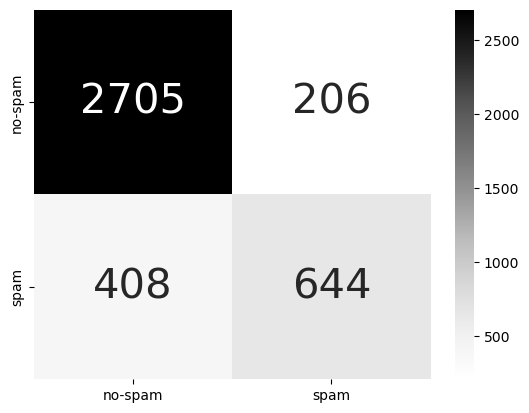

In [139]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [140]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustLinear", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4930 - Train Loss: 1.1022
Val Accuracy: 0.6595 - Val Loss: 1.0093
Validation loss decreased (inf --> 1.009307). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6608 - Train Loss: 0.7733
Val Accuracy: 0.7074 - Val Loss: 0.9171
Validation loss decreased (1.009307 --> 0.917063). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7137 - Train Loss: 0.6337
Val Accuracy: 0.6803 - Val Loss: 0.9096
Validation loss decreased (0.917063 --> 0.909573). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.7510 - Train Loss: 0.5373
Val Accuracy: 0.7483 - Val Loss: 0.9694
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7931 - Train Loss: 0.4404
Val Accuracy: 0.762

In [141]:
save_visualization_history(history, 'BiGRU_BasisCustLinear', task=2)
plotting_history(history)


In [142]:
import os
import torch

model_name="BiGRU_BasisCustLinear"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7843
Precision: 0.5692
Recall: 0.6757
F1-score: 0.5965
Confusion matrix:
 [[2427   68  286  130]
 [  16   31    5    2]
 [ 100    2  197   10]
 [ 173   24   39  453]]
              precision    recall  f1-score   support

           0     0.8936    0.8337    0.8626      2911
           1     0.2480    0.5741    0.3464        54
           2     0.3738    0.6375    0.4713       309
           3     0.7613    0.6575    0.7056       689

    accuracy                         0.7843      3963
   macro avg     0.5692    0.6757    0.5965      3963
weighted avg     0.8213    0.7843    0.7978      3963



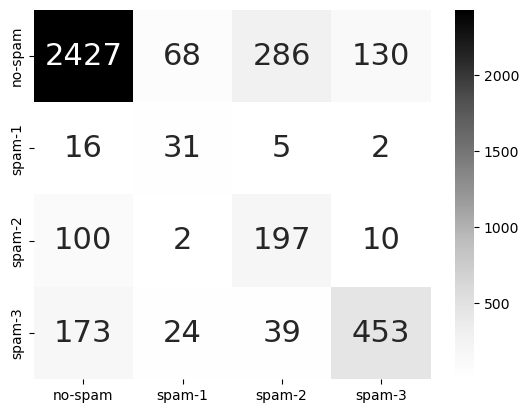

In [143]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Cust Word Embedding

## Task 1

In [144]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.6451 - Train Loss: 0.6551
Val Accuracy: 0.7640 - Val Loss: 0.5741
Validation loss decreased (inf --> 0.574094). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.7564 - Train Loss: 0.5337
Val Accuracy: 0.8269 - Val Loss: 0.5161
Validation loss decreased (0.574094 --> 0.516095). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8365 - Train Loss: 0.3989
Val Accuracy: 0.8269 - Val Loss: 0.5664
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8827 - Train Loss: 0.3011
Val Accuracy: 0.8288 - Val Loss: 0.5522
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9187 - Train Loss: 0.2205
Val Accuracy: 0.8282 - Val Loss: 0.6379
EarlyStoppin

In [145]:
save_visualization_history(history, 'BiGRU_CustWordEmbedding', task=1)
plotting_history(history)


In [146]:
import os
import torch

model_name="BiGRU_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8244
Precision: 0.7826
Recall: 0.7442
F1-score: 0.7593
Confusion matrix:
 [[2664  247]
 [ 449  603]]
              precision    recall  f1-score   support

           0     0.8558    0.9151    0.8845      2911
           1     0.7094    0.5732    0.6341      1052

    accuracy                         0.8244      3963
   macro avg     0.7826    0.7442    0.7593      3963
weighted avg     0.8169    0.8244    0.8180      3963



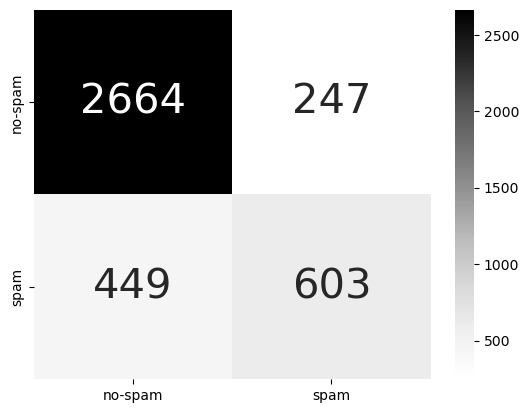

In [147]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [148]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_CustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.3696 - Train Loss: 1.3299
Val Accuracy: 0.3033 - Val Loss: 1.2667
Validation loss decreased (inf --> 1.266745). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.4539 - Train Loss: 1.1465
Val Accuracy: 0.4846 - Val Loss: 1.1711
Validation loss decreased (1.266745 --> 1.171068). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.5486 - Train Loss: 0.9139
Val Accuracy: 0.6023 - Val Loss: 1.1747
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.6715 - Train Loss: 0.6570
Val Accuracy: 0.7055 - Val Loss: 1.2415
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.7572 - Train Loss: 0.4841
Val Accuracy: 0.6646 - Val Loss: 1.2511
EarlyStoppin

In [149]:
save_visualization_history(history, 'BiGRU_CustWordEmbedding', task=2)
plotting_history(history)


In [150]:
import os
import torch

model_name="BiGRU_CustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7573
Precision: 0.5492
Recall: 0.6055
F1-score: 0.5580
Confusion matrix:
 [[2428   49  319  115]
 [  19   26    5    4]
 [ 118    1  175   15]
 [ 243   16   58  372]]
              precision    recall  f1-score   support

           0     0.8647    0.8341    0.8491      2911
           1     0.2826    0.4815    0.3562        54
           2     0.3142    0.5663    0.4042       309
           3     0.7352    0.5399    0.6226       689

    accuracy                         0.7573      3963
   macro avg     0.5492    0.6055    0.5580      3963
weighted avg     0.7913    0.7573    0.7683      3963



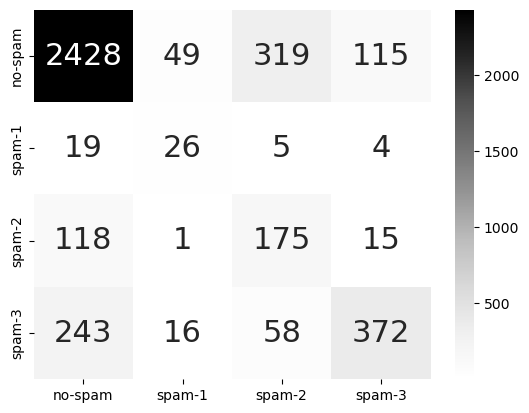

In [151]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU - Basis Cust Word Embedding

## Task 1

In [152]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustWordEmbedding", task=1).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.7774 - Train Loss: 0.5636
Val Accuracy: 0.8169 - Val Loss: 0.5552
Validation loss decreased (inf --> 0.555198). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.8330 - Train Loss: 0.4037
Val Accuracy: 0.8188 - Val Loss: 0.5263
Validation loss decreased (0.555198 --> 0.526349). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.8868 - Train Loss: 0.2943
Val Accuracy: 0.8037 - Val Loss: 0.6185
EarlyStopping counter: 1 out of 10
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.9177 - Train Loss: 0.2164
Val Accuracy: 0.8005 - Val Loss: 0.7290
EarlyStopping counter: 2 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.9356 - Train Loss: 0.1707
Val Accuracy: 0.7999 - Val Loss: 0.8496
EarlyStoppin

In [153]:
save_visualization_history(history, 'BiGRU_BasisCustWordEmbedding', task=1)
plotting_history(history)


In [154]:
import os
import torch

model_name="BiGRU_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_best_model_(1).pth")
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8246
Precision: 0.7784
Recall: 0.7574
F1-score: 0.7666
Confusion matrix:
 [[2622  289]
 [ 406  646]]
              precision    recall  f1-score   support

           0     0.8659    0.9007    0.8830      2911
           1     0.6909    0.6141    0.6502      1052

    accuracy                         0.8246      3963
   macro avg     0.7784    0.7574    0.7666      3963
weighted avg     0.8195    0.8246    0.8212      3963



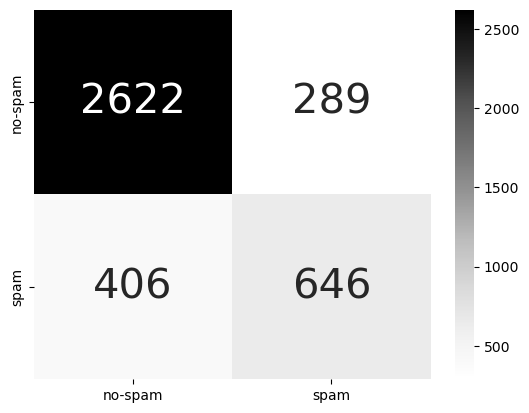

In [155]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [156]:
import torch
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="BiGRU_BasisCustWordEmbedding", task=2).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
--------------------------------------------------
Train Accuracy: 0.4877 - Train Loss: 1.1893
Val Accuracy: 0.6451 - Val Loss: 1.0799
Validation loss decreased (inf --> 1.079871). Saving model ...
Epoch 2/40
--------------------------------------------------
Train Accuracy: 0.6526 - Train Loss: 0.8238
Val Accuracy: 0.6778 - Val Loss: 0.9332
Validation loss decreased (1.079871 --> 0.933174). Saving model ...
Epoch 3/40
--------------------------------------------------
Train Accuracy: 0.7543 - Train Loss: 0.5632
Val Accuracy: 0.7363 - Val Loss: 0.9050
Validation loss decreased (0.933174 --> 0.905032). Saving model ...
Epoch 4/40
--------------------------------------------------
Train Accuracy: 0.8215 - Train Loss: 0.3903
Val Accuracy: 0.7495 - Val Loss: 1.0027
EarlyStopping counter: 1 out of 10
Epoch 5/40
--------------------------------------------------
Train Accuracy: 0.8696 - Train Loss: 0.2762
Val Accuracy: 0.800

In [157]:
save_visualization_history(history, 'BiGRU_BasisCustWordEmbedding', task=2)
plotting_history(history)


In [158]:
import os
import torch

model_name="BiGRU_BasisCustWordEmbedding"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7981
Precision: 0.6088
Recall: 0.6505
F1-score: 0.6212
Confusion matrix:
 [[2531   32  232  116]
 [  18   30    4    2]
 [ 126    3  170   10]
 [ 215   10   32  432]]
              precision    recall  f1-score   support

           0     0.8758    0.8695    0.8726      2911
           1     0.4000    0.5556    0.4651        54
           2     0.3881    0.5502    0.4552       309
           3     0.7714    0.6270    0.6918       689

    accuracy                         0.7981      3963
   macro avg     0.6088    0.6505    0.6212      3963
weighted avg     0.8131    0.7981    0.8031      3963



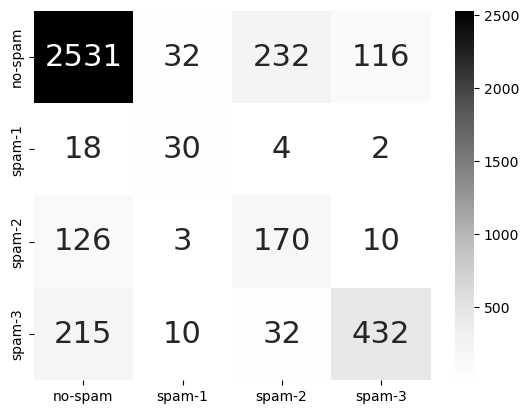

In [159]:
plotting_confusion_matrix(test_cm, task=2)
